# Direct classification with RESENT18 (Example 2: *ants* / *bees*)

In this notebook we consider the same problem of Ref. [1] (Example 2), however, in this case we do not apply transfer learning but we **directly use the neural network ResNet18** [3] which is pre-trained on the ImageNet dataset. 
Since the the images of *ants* and *bees* are two particular classes of ImageNet this is possible without
adding any additional layer to network.


## General setup
**Important:** this code makes use of the machine learning framework *PyTorch*, which is assumed to be correctly installed.

The main imported packages are: some common PyTorch libraries, and the python plotting library `matplotlib`.

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Other tools
import numpy as np
import time
import os
import copy

env: OMP_NUM_THREADS=1


In [2]:
start_time = time.time()         # Start of the computation timer
batch_size = 4

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Dataset loading

**Important:** The dataset containing images of *ants* and *bees* can be downloaded [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and should be extracted in the subfolder `../data/hymenoptera_data`. 

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, *etc.* .

In [4]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Let us show a batch of the test data, just to have an idea of the classification problem.<br>
*Hint:* re-run the next cell to see more samples.

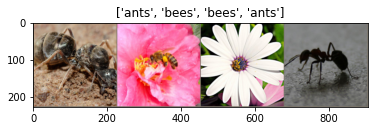

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

We are finally ready to load *ResNet18* from the `torchvision.models` zoo.

In [6]:
classical_model = torchvision.models.resnet18(pretrained=True)
    
# Use CUDA or CPU according to the "device" object.
classical_model = classical_model.to(device)

According to the design of ResNet18, the labels for bees and ants are 309 and 310, respectively. So we intoduce the next function to match this notation. I.e., this function mapes the labels of our dataset  (`0: 'ant', 1: 'bee'`) to the labels of ResNet18 (`310: 'ant', 309: 'bee'`).

In [7]:
def map_labels_to_resnet_notation(labels_zero_one):
    """Map label 0 to 310 and lebel 1 to 309."""
    new_labels = []
    for label in labels:
        if label == 0:
            new_labels.append(310)
        if label == 1:
            new_labels.append(309)
    return torch.tensor(new_labels)

We apply the model to the test dataset to compute the associated *loss* and *accuracy*.

In [8]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

all_outputs = []
# Testing loop
for inputs, labels in dataloaders['val']:
    labels = map_labels_to_resnet_notation(labels)
    classical_model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = classical_model(inputs)
        all_outputs.append(outputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 39/39
Test Loss: 1.0940 Test Acc: 0.7451        


The fact that the accuracy is relatively low is not surprising. Indeed ResNet18 is optimized with respect to 1000 different classes and so it is **not optimized** for the specific *ants* vs. *bees* classification.

## Visualize the model
Let us compute and the visualize the predictions for a batch of test data.
*Hint:* re-run the next cell to see more samples.

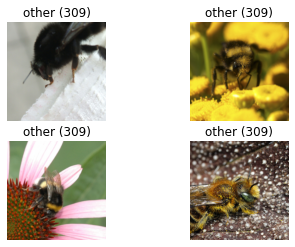

In [9]:
def visualize_model(model, num_images, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            labels = map_labels_to_resnet_notation(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                if preds[j] == 309:
                    ax.set_title("bee (309)")
                if preds[j] == 310:
                    ax.set_title("ant (310)")
                else:
                    ax.set_title(f"other ({preds[j]})")
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(classical_model, num_images=batch_size)

## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:1912.08278](https://arxiv.org/abs/1912.08278), (2019).

[3] Kaiming He, Xiangyu Zhang, Shaoqing ren and Jian Sun. _Deep residual learning for image recognition_.
  Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, 770-778 (2016). [DOI: 10.1109/CVPR.2016.90]( https://doi.org/10.1109/CVPR.2016.90).